In [1]:
# Author: Roi Yehoshua <roiyeho@gmail.com>
# August 2024
# License: MIT

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import csv

Data Loading and Preprocessing

In [3]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the digits dataset
X, y = load_digits(return_X_y=True)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standard scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Defining the Models to Compare

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': HistGradientBoostingClassifier(),
    'SVM': SVC(),
    'MLP': MLPClassifier()
}

Model Training and Evaluation

In [5]:
from sklearn.model_selection import KFold

def run_experiments(models, X_train, y_train, n_seeds=3):
    """
    Train and evaluate each model using multiple random seeds and cross-validation.
    
    Parameters:
    - models (list of tuples): A list of tuples where each tuple contains a model name (str) 
      and its corresponding Scikit-Learn estimator.
    - X_train (ndarray): Training feature matrix.
    - y_train (ndarray): Training labels.
    - n_seeds (int): Number of random seeds to use for reproducibility and evaluation. 

    Returns:
    - results (dict): A dictionary containing evaluation metrics and training times for each model. 
      The structure is as follows:
        {
            'model_name': {
                'raw_accuracy_scores': list of scores across folds and seeds,
                'accuracy_mean': float,
                'accuracy_std': float,
                'training_time': float
            },
            ...
        }
    """
    results = {} # Dictionary to store evaluation metrics and training times
    
    for name, model in models.items():
        accuracy_scores = []
        training_times = []
        
        for seed in range(42, 42 + n_seeds):
            # Set random seed if applicable
            if 'random_state' in model.get_params():
                model.set_params(random_state=seed)
            
            # Cross-validation with shuffled splits
            cv = KFold(n_splits=5, shuffle=True, random_state=seed)
            for train_index, test_index in cv.split(X_train):
                X_cv_train, X_cv_test = X_train[train_index], X_train[test_index]
                y_cv_train, y_cv_test = y_train[train_index], y_train[test_index]
    
                # Fit model and record training time
                start_time = time.time()
                model.fit(X_cv_train, y_cv_train)
                end_time = time.time()   
                training_time = end_time - start_time
                training_times.append(training_time)
    
                # Evaluate the model on the test fold
                score = model.score(X_cv_test, y_cv_test)
                accuracy_scores.append(score)
        
        results[name] = {
            'raw_accuracy_scores': accuracy_scores,  
            'accuracy_mean': np.mean(accuracy_scores),
            'accuracy_std': np.std(accuracy_scores, ddof=1),  # Bessel's correction
            'training_time': np.mean(training_times)
        }

    return results

In [6]:
results = run_experiments(models, X_train, y_train)

In [7]:
df_results = pd.DataFrame.from_dict(results, orient='index')
df_results = df_results.drop(['raw_accuracy_scores'], axis=1)
print(df_results)

                     accuracy_mean  accuracy_std  training_time
Logistic Regression       0.968686      0.008316       0.044167
KNN                       0.971696      0.010683       0.000865
Random Forest             0.971926      0.010893       0.279609
Gradient Boosting         0.967756      0.008047       2.199793
SVM                       0.980508      0.008619       0.037620
MLP                       0.975640      0.010851       1.199283


Logging

In [8]:
from datetime import datetime

# Create the /logs directory if it doesn't exist
os.makedirs('logs', exist_ok=True)

# Generate a timestamped filename
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
filename = f'logs/digits_results_{timestamp}.csv'

# Write results to CSV
with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Model Name', 'Raw Accuracy Scores', 'Accuracy Mean', 'Accuracy Std', 
                     'Training Time'])
    for model_name, metrics in results.items():
        writer.writerow([model_name, metrics['raw_accuracy_scores'], metrics['accuracy_mean'], 
                         metrics['accuracy_std'], metrics['training_time']])

Visualization of the Results

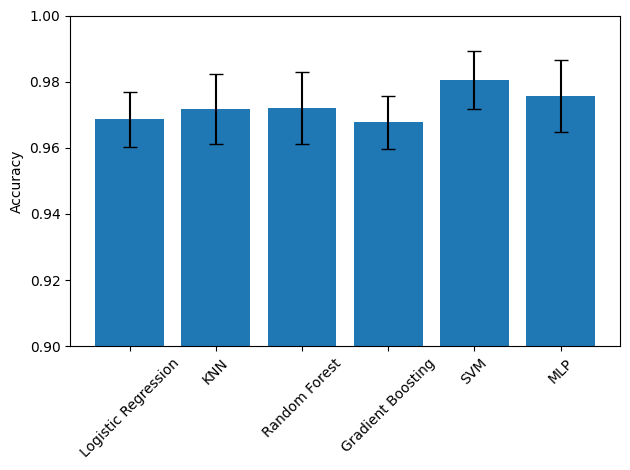

In [9]:
# Plot accuracy results
accuracies = [metrics['accuracy_mean'] for metrics in results.values()]
std_errors = [metrics['accuracy_std'] for metrics in results.values()]
model_names = list(results.keys())

plt.bar(model_names, accuracies, yerr=std_errors, capsize=5)
plt.ylabel('Accuracy')
plt.ylim([0.9, 1.0])
plt.xticks(rotation=45)
plt.tight_layout() 
plt.savefig('figures/model_comparison_accuracy.pdf')

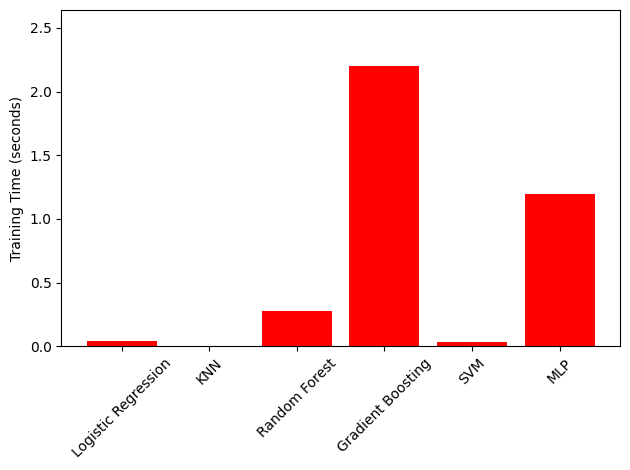

In [10]:
# Plot training times
training_times = [results[name]['training_time'] for name in model_names]

plt.bar(model_names, training_times, color='red')
plt.ylabel('Training Time (seconds)')
plt.ylim([0, max(training_times) * 1.2])  
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('figures/model_comparison_training_time.pdf')

Confidence Intervals

In [11]:
from scipy.stats import norm

def compute_confidence_interval(scores, confidence=0.95):
    """Compute the confidence interval for a model's accuracy.
    Arguments:
    - scores: Cross-validation accuracy scores for the model.
    - confidence: The confidence level, typically 0.95 for a 95% confidence interval.
    Returns:
    - tuple: (lower bound, upper bound) of the confidence interval.
    """
    mean_score = np.mean(scores)
    sem = np.std(scores, ddof=1) / np.sqrt(len(scores)) # standard error of mean
    z_value = norm.ppf((1 + confidence) / 2)  
    margin_of_error = z_value * sem
    return mean_score - margin_of_error, mean_score + margin_of_error

In [12]:
# Compute confidence intervals for each model
for name, metrics in results.items():
    lower, upper = compute_confidence_interval(metrics['raw_accuracy_scores'])
    results[name]['confidence_interval'] = (lower, upper)

In [13]:
# Show the confidence intervals in a table
df_results = pd.DataFrame([
    {model: f"{data['accuracy_mean']:.3f} ({data['confidence_interval'][0]:.3f}, "
            f"{data['confidence_interval'][1]:.3f})"
     for model, data in results.items()}
], index=['Accuracy (95% CI)'])

df_results

,Logistic Regression,KNN,Random Forest,Gradient Boosting,SVM,MLP
Accuracy (95% CI),"0.969 (0.964, 0.973)","0.972 (0.966, 0.977)","0.972 (0.966, 0.977)","0.968 (0.964, 0.972)","0.981 (0.976, 0.985)","0.976 (0.970, 0.981)"


Statistical Significance Testing

In [14]:
from scipy.stats import ttest_rel

# Extract the accuracy scores of the two models
scores_svm = np.array(results['SVM']['raw_accuracy_scores'])
scores_mlp = np.array(results['MLP']['raw_accuracy_scores'])

# Conduct paired t-test
t_stat, p_val = ttest_rel(scores_svm, scores_mlp)
print(f'Paired t-test statistic: {t_stat:.4f}, p-value: {p_val:.4f}')

Paired t-test statistic: 2.5430, p-value: 0.0234


In [15]:
from scipy.stats import wilcoxon

# Conduct Wilcoxon signed-rank test
w_stat, p_val = wilcoxon(scores_svm, scores_mlp)
print(f'Wilcoxon test statistic: {w_stat:.4f}, p-value: {p_val:.4f}')

Wilcoxon test statistic: 23.5000, p-value: 0.0413


In [16]:
from scipy.stats import friedmanchisquare

# Extract relevant arrays from the results dictionary
model_scores = {model: data['raw_accuracy_scores']
                for model, data in results.items()}

# Conduct the Friedman test
f_stat, p_val = friedmanchisquare(*model_scores.values())
print(f'Friedman test statistic: {f_stat:.4f}, p-value: {p_val:.4f}')

Friedman test statistic: 25.2888, p-value: 0.0001


In [17]:
import scikit_posthocs as sp

df_scores = pd.DataFrame(model_scores)
nemenyi_results = sp.posthoc_nemenyi_friedman(df_scores)
nemenyi_results

,Logistic Regression,KNN,Random Forest,Gradient Boosting,SVM,MLP
Logistic Regression,1.000000,0.850735,0.872331,0.997944,0.001616,0.239574
KNN,0.850735,1.000000,1.000000,0.591718,0.078461,0.909831
Random Forest,0.872331,1.000000,1.000000,0.624125,0.068976,0.892042
Gradient Boosting,0.997944,0.591718,0.624125,1.000000,0.000254,0.088978
SVM,0.001616,0.078461,0.068976,0.000254,1.000000,0.559106
MLP,0.239574,0.909831,0.892042,0.088978,0.559106,1.000000


Critical Difference Diagram

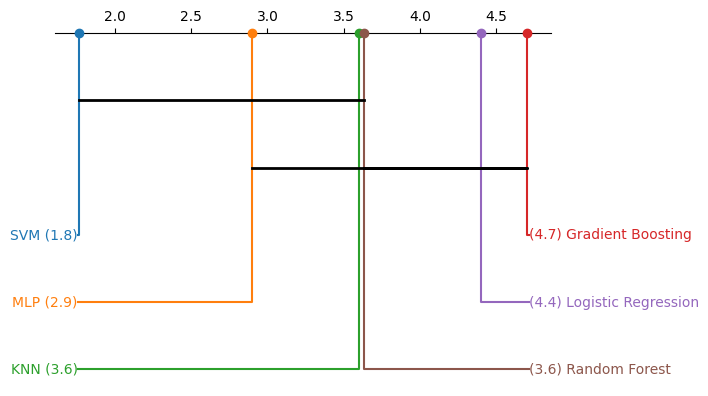

In [18]:
# Calculate ranks of the scores and the mean ranks
df_ranks = df_scores.rank(axis=1, method='average', ascending=False)
mean_ranks = df_ranks.mean(axis=0)

# Plot CD diagram
sp.critical_difference_diagram(mean_ranks, nemenyi_results)
plt.savefig('figures/cd_diagram.pdf', bbox_inches='tight')

Final evaluation on the test set

In [19]:
# Evaluate models that showed no significant difference during CV
selected_models = ['SVM', 'MLP', 'KNN', 'Random Forest']
test_results = {}
for name in selected_models:
    model = models[name]
    
    # Retrain on the full training set
    if 'random_state' in model.get_params():
        model.set_params(random_state=42)
    model.fit(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    test_results[name] = test_accuracy

# Display the test results
print("Accuracy on the test set:")
for model_name, test_accuracy in test_results.items():
    print(f'{model_name}: {test_accuracy:.4f}')

Accuracy on the test set:
SVM: 0.9806
MLP: 0.9806
KNN: 0.9750
Random Forest: 0.9722
